<a href="https://colab.research.google.com/github/diegoramfin/PCA-Based-Portfolio-Risk-Decomposition/blob/main/Portfolio_Risk_Decomposition_Using_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intial Portfolio Risk Research Decomposition

Using Ledoit-Wolf along with Eigen decompositon we find covariance between assets, and the factor loadings.

In [40]:
!pip install yfinance

In [41]:
# Intial Market Data Grab

import yfinance as yf
import pandas as pd
import numpy as np

tickers = ['AAPL','MSFT','GOOGL','AMZN','TSLA','JPM','JNJ','XOM','PG','NVDA']
data = yf.download(tickers, start='2021-01-01', end='2025-01-01', auto_adjust=False)['Adj Close']
prices = data.dropna(how='all')
returns = np.log(prices / prices.shift(1)).dropna()
valid_assets = returns.columns[returns.isnull().mean() < 0.5]
returns = returns[valid_assets].dropna()
returns.head()

[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,NVDA,PG,TSLA,XOM
Date,,,,,,,,,,
2021-01-05,0.012288,0.009955,0.008032,0.011689,0.005426,0.000964,0.021967,0.006365,0.007291,0.047067
2021-01-06,-0.034241,-0.025212,-0.009917,0.009366,0.045887,-0.026271,-0.060762,0.010472,0.027995,0.025197
2021-01-07,0.033554,0.007549,0.029431,0.003373,0.032311,0.028060,0.056220,-0.009391,0.076448,0.007815
2021-01-08,0.008594,0.006475,0.013152,-0.002060,0.001104,0.006074,-0.005052,-0.000432,0.075481,0.011060
2021-01-11,-0.023524,-0.021754,-0.023377,-0.004195,0.014814,-0.009746,0.025635,-0.006796,-0.081442,0.029905


In [42]:
# Covariance Estimation
'''
Calculates the covariance matrix of the asset returns using the Ledoit-Wolf method.
'''

from sklearn.covariance import LedoitWolf

lw = LedoitWolf().fit(returns.values)
cov_matrix = lw.covariance_
cols = returns.columns
N = len(cols)

In [43]:
#Eigen Decomposition
'''
This cell performs eigen decomposition on the covariance matrix to get eigenvalues and eigenvectors, and calculates factor loadings.
'''

from pickle import load

import numpy.linalg as la

eigvals, eigvecs = la.eigh(cov_matrix)
eigvals = eigvals[::-1]
eigvecs = eigvecs[:, ::-1]

explained_var_ratio = eigvals / eigvals.sum()


factor_loadings = pd.DataFrame(
    eigvecs,
    index = returns.columns,
    columns=[f'PC{i+1}' for i in range (len(returns.columns))]
)

factor_loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Ticker,,,,,,,,,,
AAPL,-0.245117,-0.096218,0.201255,0.102540,-0.364641,0.255061,-0.376100,-0.671456,0.295686,-0.043454
AMZN,-0.325648,-0.234500,0.313741,0.375459,0.627352,-0.329667,-0.268258,0.054388,0.144718,-0.038035
GOOGL,-0.270596,-0.231481,0.298540,0.275979,-0.122032,0.364371,0.692255,0.179012,0.218506,-0.035203
JNJ,-0.008745,-0.024629,0.201776,-0.003612,-0.350404,-0.185121,-0.208405,0.376843,0.274932,0.735192
JPM,-0.117823,-0.047550,0.331481,-0.348164,-0.183776,-0.680845,0.374498,-0.318049,-0.109787,-0.044469


In [44]:
#Portfolio Variance & Risk Contribution
'''
This cell calculates the portfolio variance and the contribution of each principal component to the portfolio risk.
'''

weights = np.full(N, 1/N)

#Portfolio Variance
port_var = float(weights.T @ cov_matrix @ weights)

# Absolute Factor Contributions
w_f = eigvecs.T @ weights
pc_risk_contrib = (w_f**2) * eigvals
pc_risk_contrib = pc_risk_contrib / pc_risk_contrib.sum() * port_var


# Transform weights into factor space: w_f = Q^T w, where Q = eigvecs
# Different Approach to Absolute Factor but done to show creativity of approaches

Q = eigvecs                           # (N, N)
w_f = Q.T @ weights                   # (N,)
factor_contrib = (w_f**2) * eigvals
factor_contrib_ratio = factor_contrib / factor_contrib.sum()


print(f"\nPortfolio variance: {port_var:.6e}")

print("Absolute Factor Contributions (Scaled in Proportion of Total Port Var):")
for i in range(len(pc_risk_contrib)):
    print(f"  PC{i+1}: {pc_risk_contrib[i]:.6e}")

print("Relative Factor Contribution ratios (% of Total Port Var):")
for i in range(len(factor_contrib_ratio)):
    print(f"  PC{i+1}: {factor_contrib_ratio[i]:.4f}")


Portfolio variance: 1.630608e-04
Absolute Factor Contributions (Scaled in Proportion of Total Port Var):
  PC1: 1.481836e-04
  PC2: 3.085655e-06
  PC3: 9.528704e-06
  PC4: 5.766930e-07
  PC5: 1.180935e-06
  PC6: 1.087130e-07
  PC7: 1.810561e-07
  PC8: 2.072823e-07
  PC9: 4.592560e-09
  PC10: 3.598035e-09
Relative Factor Contribution ratios (% of Total Port Var):
  PC1: 0.9088
  PC2: 0.0189
  PC3: 0.0584
  PC4: 0.0035
  PC5: 0.0072
  PC6: 0.0007
  PC7: 0.0011
  PC8: 0.0013
  PC9: 0.0000
  PC10: 0.0000


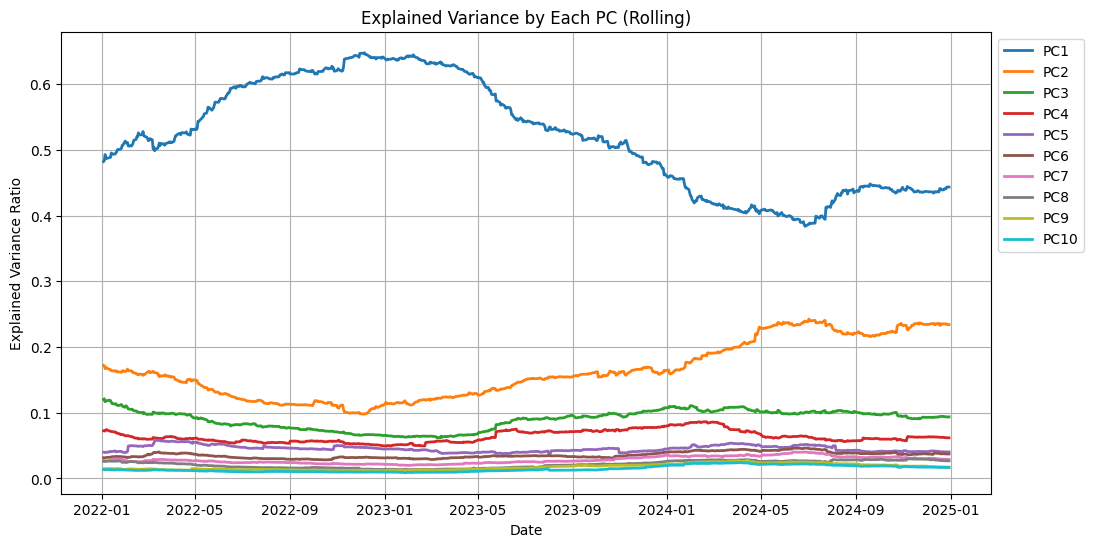

In [45]:
# Rolling Eigen Decomposition on Ledoit–Wolf Covariance

import matplotlib.pyplot as plt
import numpy as np

window = 252
rolling_explained_var = []
rolling_idx = []

for end in range(window, len(returns)):
    sub = returns.iloc[end-window:end]
    # shrinkage covariance per window
    lw = LedoitWolf().fit(sub.values)
    C = lw.covariance_
    # eigen on C
    vals, vecs = la.eigh(C)
    vals = vals[::-1]
    # explained variance ratio for this window
    evr = vals / vals.sum()
    rolling_explained_var.append(evr)
    rolling_idx.append(sub.index[-1])

rolling_explained_var = pd.DataFrame(rolling_explained_var,
                                     index=pd.DatetimeIndex(rolling_idx),
                                     columns=[f'PC{i+1}' for i in range(len(returns.columns))])

plt.figure(figsize=(12,6))
for col in rolling_explained_var.columns:
    plt.plot(rolling_explained_var[col], label=col, linewidth=2)
plt.title("Explained Variance by Each PC (Rolling)")
plt.xlabel("Date")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [46]:
# Factor Returns via Projection


R = returns.values                    # (T, N)
F = R @ eigvecs                       # (T, N) factor returns (PC1..PCN)
factor_returns = pd.DataFrame(F, index=returns.index, columns=[f"PC{i+1}" for i in range(N)])


F_scaled = pd.DataFrame(F / np.sqrt(eigvals),                 # not required for most reporting
                        index=returns.index,
                        columns=[f"PC{i+1}" for i in range(N)])

factor_returns.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Date,,,,,,,,,,
2021-01-05,-0.028159,-0.013534,0.023749,-0.034831,0.004515,0.013644,-0.011802,0.008989,0.009304,0.002576
2021-01-06,0.034530,0.063576,0.043294,-0.033267,-0.005193,-0.029249,0.026532,0.013329,-0.002319,-0.005049
2021-01-07,-0.107649,0.013381,0.000733,-0.017895,-0.018334,0.000821,0.014743,-0.016425,-0.006120,0.009822
2021-01-08,-0.054062,0.053900,0.013954,0.000705,0.002315,0.010715,0.003929,0.003457,-0.001739,-0.001672
2021-01-11,0.055422,-0.062399,-0.013777,-0.052969,0.008149,-0.006968,0.001556,0.000216,-0.007405,0.001613


In [47]:
#Per-asset marginal contribution to risk (MCR) and component contribution (CCR)
# MCR_i = (Sigma w)_i / sqrt(w^T Sigma w); CCR_i = w_i * MCR_i * sqrt(w^T Sigma w)

Sigma_w = cov_matrix @ weights
mcr = Sigma_w / np.sqrt(port_var)             # marginal contribution to stdev
ccr = weights * mcr * np.sqrt(port_var)       # component contribution to stdev
mcr_df = pd.DataFrame({"MCR": mcr, "CCR": ccr}, index=cols).sort_values("CCR", ascending=False)
mcr_df.head()


,MCR,CCR
Ticker,,
TSLA,0.026380,0.000034
NVDA,0.025302,0.000032
AMZN,0.016913,0.000022
GOOGL,0.014661,0.000019
AAPL,0.013098,0.000017


In [48]:
# Low-Rank Covariance Approximation

threshold = 0.75  # retain 75% of variance; tune to liking
cum = np.cumsum(explained_var_ratio)
k = int(np.searchsorted(cum, threshold) + 1)

# Low-rank covariance: Q_k diag(eigvals_k) Q_k^T

Qk = Q[:, :k]
Lk = np.diag(eigvals[:k])
cov_lowrank = Qk @ Lk @ Qk.T

print(f"Selected k={k} PCs covering {cum[k-1]:.1%} of total variance.")


Selected k=3 PCs covering 77.4% of total variance.


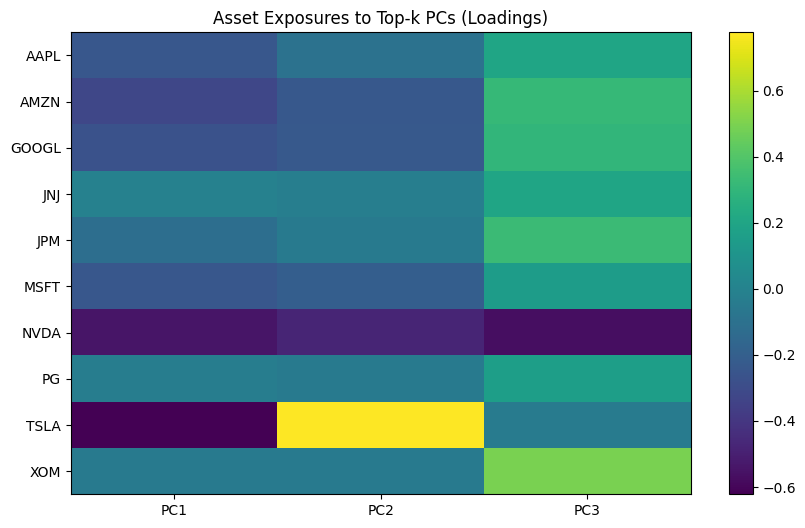

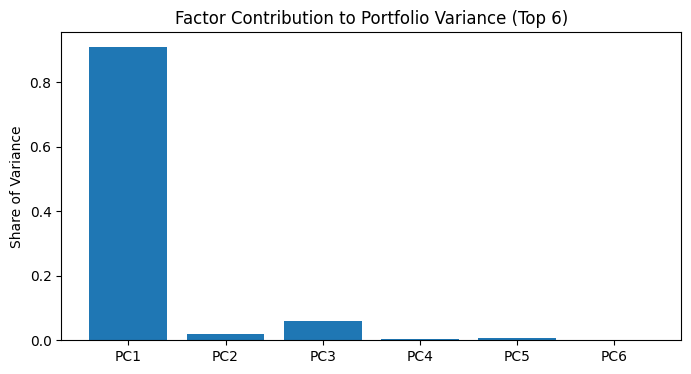

In [49]:
# --- Loadings Heatmap for top-k PCs ---
import matplotlib.pyplot as plt

topk_load = pd.DataFrame(Qk, index=cols, columns=[f"PC{i+1}" for i in range(k)])
topk_load.sort_index(inplace=True)

plt.figure(figsize=(10, max(6, int(N*0.25))))
plt.imshow(topk_load.values, aspect='auto')
plt.colorbar()
plt.yticks(range(len(topk_load.index)), topk_load.index)
plt.xticks(range(k), topk_load.columns)
plt.title("Asset Exposures to Top-k PCs (Loadings)")
plt.show()

# --- Factor contribution bar chart ---
plt.figure(figsize=(8,4))
plt.bar([f"PC{i+1}" for i in range(6)], factor_contrib_ratio[:6])
plt.title("Factor Contribution to Portfolio Variance (Top 6)")
plt.ylabel("Share of Variance")
plt.show()


# Factors Deep Dive
In this section we seek to identify what each factor is in relation to the market. Correlation allows us to identify how they are related to certain market indicators. Such as Oil (WTI), Dollar (DXY), GSPC (SP500).

In [50]:
# Identify relevant market factors
# Broad market: S&P 500
# Technology sector (many of the tickers are tech-related): XLK
# Growth stocks (many of the tickers are growth stocks): VUG (Vanguard Growth ETF)

market_factors_tickers = ['^GSPC', 'XLK', 'VUG', 'TLT', 'WTI', 'DX-Y.NYB']
print(market_factors_tickers)

['^GSPC', 'XLK', 'VUG', 'TLT', 'WTI', 'DX-Y.NYB']


In [51]:
import yfinance as yf
import numpy as np
import pandas as pd

# Download market factor data
market_data = yf.download(market_factors_tickers, start=returns.index.min(), end=returns.index.max(), auto_adjust=False)['Adj Close']

# Calculate logarithmic returns
market_returns = np.log(market_data / market_data.shift(1))

# Align market factor returns with asset returns and handle missing values
market_returns = market_returns.reindex(returns.index).dropna()

# Display the first few rows of the market factor returns
market_returns.head()

[*********************100%***********************]  6 of 6 completed


Ticker,DX-Y.NYB,TLT,VUG,WTI,XLK,^GSPC
Date,,,,,,
2021-01-06,0.001006,-0.020741,-0.011004,0.016737,-0.017396,0.005694
2021-01-07,0.003345,-0.008854,0.022833,-0.008334,0.026598,0.014738
2021-01-08,0.003001,-0.003233,0.010640,0.012474,0.006445,0.005477
2021-01-11,0.004872,-0.001653,-0.013555,0.008230,-0.008294,-0.006576
2021-01-12,-0.005427,-0.000795,-0.001935,0.055791,-0.004792,0.000416


In [52]:
# Concatenate factor returns and market returns
combined_returns = pd.concat([factor_returns, market_returns], axis=1)

# Calculate the correlation matrix
factor_market_correlation = combined_returns.corr().loc[factor_returns.columns, market_returns.columns]

# Display the correlation matrix
display(factor_market_correlation)

Ticker,DX-Y.NYB,TLT,VUG,WTI,XLK,^GSPC
PC1,0.269192,-0.061985,-0.913388,-0.146543,-0.878431,-0.839519
PC2,0.070745,-0.011326,-0.260387,-0.037280,-0.308297,-0.254336
PC3,-0.130169,-0.078171,0.167409,0.360345,0.086172,0.324309
PC4,0.086746,0.179168,0.066187,-0.477728,0.008785,-0.092416
PC5,0.095745,-0.053784,-0.077258,0.192006,-0.148128,-0.157044
PC6,0.039374,0.032983,-0.006244,0.245179,0.037787,-0.088302
PC7,0.050534,-0.118884,-0.050339,-0.019583,-0.100340,-0.054607
PC8,-0.011670,0.088864,-0.036551,-0.009808,-0.101297,0.003388
PC9,-0.036342,0.075428,-0.035201,-0.029547,-0.093892,-0.023061
PC10,0.037378,-0.022235,-0.014139,-0.006184,-0.000370,-0.017437


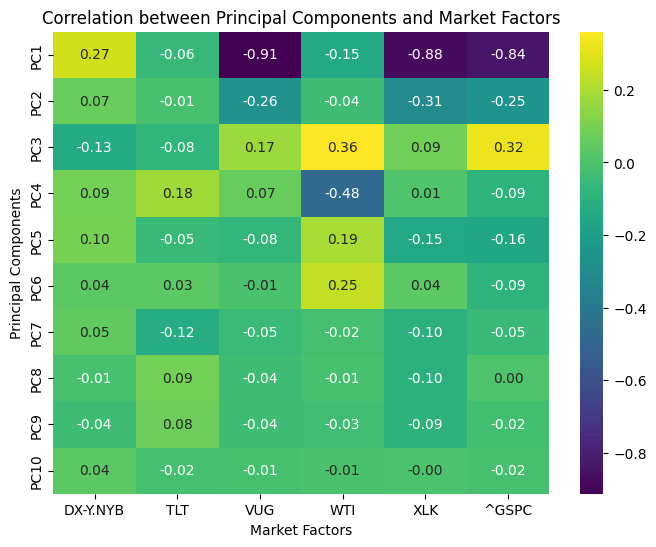

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(factor_market_correlation, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation between Principal Components and Market Factors")
plt.xlabel("Market Factors")
plt.ylabel("Principal Components")
plt.show()

In [54]:
print("Principal Component Interpretation based on Market Factor Correlation:")
for pc in factor_market_correlation.index:
    highest_corr_factor = factor_market_correlation.loc[pc].abs().idxmax()
    highest_corr_value = factor_market_correlation.loc[pc, highest_corr_factor]
    print(f"{pc}: Highest absolute correlation with {highest_corr_factor} ({highest_corr_value:.4f})")

Principal Component Interpretation based on Market Factor Correlation:
PC1: Highest absolute correlation with VUG (-0.9134)
PC2: Highest absolute correlation with XLK (-0.3083)
PC3: Highest absolute correlation with WTI (0.3603)
PC4: Highest absolute correlation with WTI (-0.4777)
PC5: Highest absolute correlation with WTI (0.1920)
PC6: Highest absolute correlation with WTI (0.2452)
PC7: Highest absolute correlation with TLT (-0.1189)
PC8: Highest absolute correlation with XLK (-0.1013)
PC9: Highest absolute correlation with XLK (-0.0939)
PC10: Highest absolute correlation with DX-Y.NYB (0.0374)


In [64]:
def pc_summary_table(factor_market_correlation, explained_variance_ratio=None, top_n=3):
    rows = []

    for pc in factor_market_correlation.index:
        row = factor_market_correlation.loc[pc].dropna()
        top_factors = row.abs().nlargest(top_n).index
        for f in top_factors:
            ve = explained_variance_ratio.loc[pc] if isinstance(explained_variance_ratio, pd.Series) else None
            rows.append({
                "PC": pc,
                "Variance_Explained": ve,
                "Factor": f,
                "Correlation": row[f],
                "Absolute Correlation:": abs(row[f])
            })
    return pd.DataFrame(rows)

# Convert explained_var_ratio to a pandas Series before passing it to the function
explained_var_ratio_series = pd.Series(explained_var_ratio, index=factor_market_correlation.index)

summary_df = pc_summary_table(factor_market_correlation, explained_var_ratio_series, top_n=2)
print(summary_df)

      PC  Variance_Explained    Factor  Correlation  Absolute Correlation:
0    PC1            0.527829       VUG    -0.913388               0.913388
1    PC1            0.527829       XLK    -0.878431               0.878431
2    PC2            0.160440       XLK    -0.308297               0.308297
3    PC2            0.160440       VUG    -0.260387               0.260387
4    PC3            0.086054       WTI     0.360345               0.360345
5    PC3            0.086054     ^GSPC     0.324309               0.324309
6    PC4            0.071233       WTI    -0.477728               0.477728
7    PC4            0.071233       TLT     0.179168               0.179168
8    PC5            0.041046       WTI     0.192006               0.192006
9    PC5            0.041046     ^GSPC    -0.157044               0.157044
10   PC6            0.034672       WTI     0.245179               0.245179
11   PC6            0.034672     ^GSPC    -0.088302               0.088302
12   PC7            0.028

In [70]:
def factor_influence(summary_df):
    """
    Aggregate factor influence across all PCs, weighting by explained variance.
    summary_df: output of interpret_pcs()

    Returns DataFrame sorted by total influence.
    """
    df = summary_df.copy()
    if "Variance_Explained" in df and df["Variance_Explained"].notna().any():
        # Use the correct column name 'Absolute Correlation:'
        df["Weighted_Influence"] = df["Variance_Explained"] * df["Absolute Correlation:"]
    else:
        # Use the correct column name 'Absolute Correlation:'
        df["Weighted_Influence"] = df["Absolute Correlation:"]  # fallback
    return (
        # Remove 'Factor_Label' as it does not exist in summary_df
        df.groupby("Factor")["Weighted_Influence"]
          .sum()
          .sort_values(ascending=False)
          .reset_index()
    )


influence_df = factor_influence(summary_df)
print(influence_df.head(10))  # Top 10 most influential factors across PCs

     Factor  Weighted_Influence
0       VUG            0.523889
1       XLK            0.519675
2       WTI            0.081421
3     ^GSPC            0.037416
4       TLT            0.019566
5  DX-Y.NYB            0.000471


In [67]:
def pc_factor_breakdown(summary_df, top_n=5):
    """
    For each PC, return the top N factors most correlated with it.

    Parameters:
        summary_df: output of interpret_pcs()
        top_n (int): number of top factors per PC

    Returns:
        dict: {PC: DataFrame of top factors}
    """
    results = {}
    grouped = summary_df.groupby("PC")

    # Force sorted order: PC1, PC2, PC3, ...
    for pc in sorted(grouped.groups.keys(), key=lambda x: int(x.replace("PC", ""))):
        group = grouped.get_group(pc)
        top_factors = (
            group.sort_values("Absolute Correlation:", ascending=False)
                 .head(top_n)
                 .copy()
        )
        top_factors["Weighted_Influence"] = (
            top_factors["Variance_Explained"] * top_factors["Absolute Correlation:"]
        )
        results[pc] = top_factors[["Factor", "Absolute Correlation:",
                                   "Variance_Explained", "Weighted_Influence"]]

    return results


pc_breakdowns = pc_factor_breakdown(summary_df, top_n=5)

for pc, df in pc_breakdowns.items():
    print(f"\n{pc} (Top 5 factors)")
    print(df)



PC1 (Top 5 factors)
  Factor  Absolute Correlation:  Variance_Explained  Weighted_Influence
0    VUG               0.913388            0.527829            0.482112
1    XLK               0.878431            0.527829            0.463661

PC2 (Top 5 factors)
  Factor  Absolute Correlation:  Variance_Explained  Weighted_Influence
2    XLK               0.308297             0.16044            0.049463
3    VUG               0.260387             0.16044            0.041777

PC3 (Top 5 factors)
  Factor  Absolute Correlation:  Variance_Explained  Weighted_Influence
4    WTI               0.360345            0.086054            0.031009
5  ^GSPC               0.324309            0.086054            0.027908

PC4 (Top 5 factors)
  Factor  Absolute Correlation:  Variance_Explained  Weighted_Influence
6    WTI               0.477728            0.071233            0.034030
7    TLT               0.179168            0.071233            0.012763

PC5 (Top 5 factors)
  Factor  Absolute Correlation:

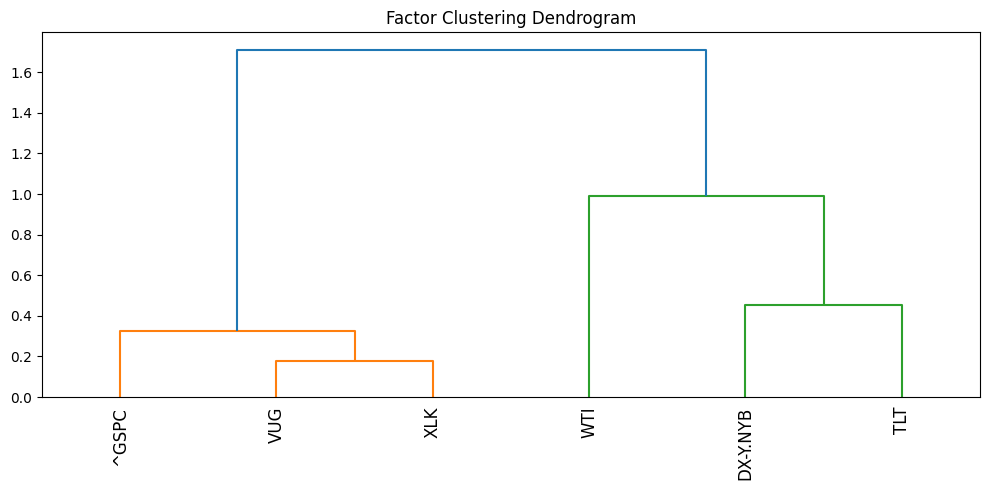

In [58]:
from scipy.cluster.hierarchy import linkage, fcluster


def cluster_factors(factor_market_correlation, method="ward", metric="euclidean", max_clusters=None):
    """
    Cluster factors based on their correlation profiles across PCs.

    Parameters:
        factor_market_correlation (pd.DataFrame): PCs (rows) x Factors (columns)
        method (str): linkage method ("ward", "average", etc.)
        metric (str): distance metric
        max_clusters (int): optional, max number of clusters

    Returns:
        dict: {cluster_id: [factor_names]}
    """
    factor_profiles = factor_market_correlation.T.values  # shape: factors x PCs
    Z = linkage(factor_profiles, method=method, metric=metric)

    if max_clusters:
        labels = fcluster(Z, max_clusters, criterion="maxclust")
    else:
        labels = fcluster(Z, t=1.0, criterion="inconsistent")

    clusters = {}
    for factor, label in zip(factor_market_correlation.columns, labels):
        clusters.setdefault(label, []).append(factor)

    return clusters, Z

clusters, Z = cluster_factors(factor_market_correlation)

from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt


def plot_dendrogram(Z, factor_names, title="Factor Clustering Dendrogram"):
    """
    Plots dendrogram of factor clustering.
    """
    plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=factor_names, leaf_rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Call plot_dendrogram with the linkage matrix Z and the original factor names
plot_dendrogram(Z, factor_market_correlation.columns)

# Risk Findings

In this section I map out what the clustering along with the market factors correlating with the PCs mean for the portfolio.


The total variance of the portfolio is, 1.630608e-04 when compared to the factor contributions we find that much of this stems from k=3, ['PC1' 'PC2' 'PC3']: covering 77.4% of total variance.
Absolute Factor Contributions (Scaled in Proportion of Total Port Var) for Top K PCs:
  PC1: 1.481836e-04
  PC2: 3.085655e-06
  PC3: 9.528704e-06
Relative Factor Contribution ratios (% of Total Port Var) for Top K PCs:
  PC1: 0.9088
  PC2: 0.0189
  PC3: 0.0584

--- Asset Risk Sheet (Top 3 PCs, Cumulative Returns) ---


,Weight,PC1,PC2,PC3,PC1_CumReturn,PC2_CumReturn,PC3_CumReturn
Ticker,,,,,,,
AAPL,0.1,-0.245117,-0.096218,0.201255,-0.973809,-0.81217,-0.115032
AMZN,0.1,-0.325648,-0.234500,0.313741,-0.973809,-0.81217,-0.115032
GOOGL,0.1,-0.270596,-0.231481,0.298540,-0.973809,-0.81217,-0.115032
JNJ,0.1,-0.008745,-0.024629,0.201776,-0.973809,-0.81217,-0.115032
JPM,0.1,-0.117823,-0.047550,0.331481,-0.973809,-0.81217,-0.115032
MSFT,0.1,-0.244996,-0.204128,0.148251,-0.973809,-0.81217,-0.115032
NVDA,0.1,-0.544856,-0.479351,-0.572327,-0.973809,-0.81217,-0.115032
PG,0.1,-0.026791,-0.053157,0.159903,-0.973809,-0.81217,-0.115032
TSLA,0.1,-0.622199,0.776421,-0.038127,-0.973809,-0.81217,-0.115032


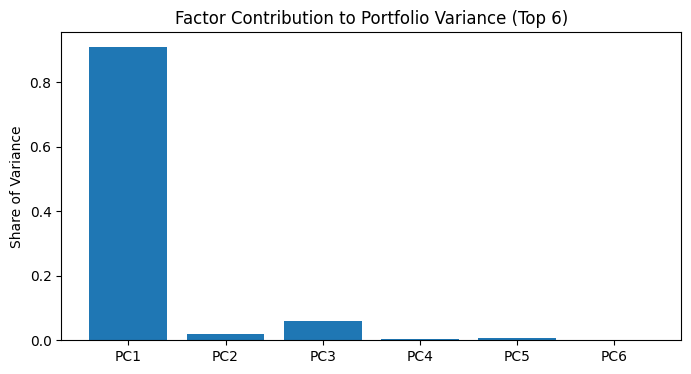

In [116]:
'''
This section aims to break down the information gathered identify key points of risk in the portfolio with steps to minimize.
'''

print(f"The total variance of the portfolio is, {port_var:.6e} when compared to the factor contributions we find that much of this stems from k={k}, {topk_load.columns.values}: covering {cum[k-1]:.1%} of total variance.")

print("Absolute Factor Contributions (Scaled in Proportion of Total Port Var) for Top K PCs:")
# Iterate only up to k for absolute contributions
for i in range(k):
    print(f"  PC{i+1}: {pc_risk_contrib[i]:.6e}")

print("Relative Factor Contribution ratios (% of Total Port Var) for Top K PCs:")
# Iterate only up to k for relative contributions
for i in range(k):
    print(f"  PC{i+1}: {factor_contrib_ratio[i]:.4f}")


if 'weights' in locals() and 'cols' in locals() and 'factor_loadings' in locals() and 'factor_returns' in locals():
    asset_weights_df = pd.DataFrame({'Weight': weights}, index=cols)

    # Select loadings for PC1, PC2, and PC3
    top3_loadings = factor_loadings[['PC1', 'PC2', 'PC3']].copy()

    # --- Use cumulative returns instead of latest ---
    # factor_returns is assumed to be daily returns of PCs
    cumulative_factor_returns = (1 + factor_returns[['PC1', 'PC2', 'PC3']]).cumprod() - 1
    cum_returns = cumulative_factor_returns.iloc[-1].rename("Cumulative Factor Return").to_frame().T

    # Repeat for each asset so we can merge cleanly
    cum_returns_repeated = cum_returns.loc[cum_returns.index.repeat(len(cols))]
    cum_returns_repeated.index = cols

    # Build the risk sheet
    risk_sheet_df = asset_weights_df.copy()
    risk_sheet_df = risk_sheet_df.join(top3_loadings)

    # Rename cumulative return columns
    cum_returns_repeated.columns = [f"{col}_CumReturn" for col in cum_returns_repeated.columns]
    risk_sheet_df = risk_sheet_df.join(cum_returns_repeated)

    print("\n--- Asset Risk Sheet (Top 3 PCs, Cumulative Returns) ---")
    display(risk_sheet_df)

else:
    print("\nRequired data (weights, cols, factor_loadings, factor_returns) not available. Please run the relevant cells.")

# --- Factor contribution bar chart ---
plt.figure(figsize=(8,4))
plt.bar([f"PC{i+1}" for i in range(6)], factor_contrib_ratio[:6])
plt.title("Factor Contribution to Portfolio Variance (Top 6)")
plt.ylabel("Share of Variance")
plt.show()

Summary Table (Top 3 PCs):
    PC  Variance_Explained Factor  Correlation  Absolute Correlation:
0  PC1            0.527829    VUG    -0.913388               0.913388
1  PC1            0.527829    XLK    -0.878431               0.878431
2  PC2            0.160440    XLK    -0.308297               0.308297
3  PC2            0.160440    VUG    -0.260387               0.260387
4  PC3            0.086054    WTI     0.360345               0.360345
5  PC3            0.086054  ^GSPC     0.324309               0.324309


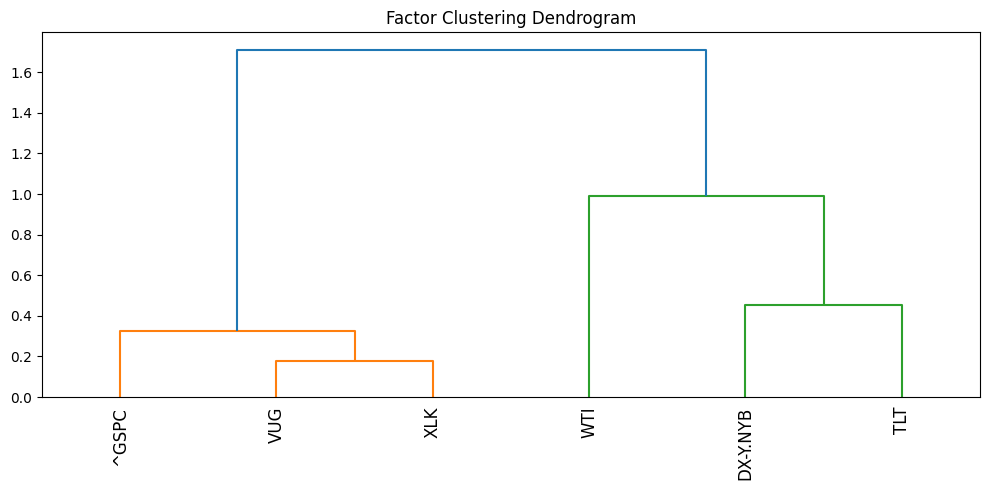

In [120]:
# Filter factor_market_correlation to include only PC1, PC2, and PC3
top3_factor_market_correlation = factor_market_correlation.loc[['PC1', 'PC2', 'PC3']]

# Convert explained_var_ratio to a pandas Series before passing it to the function
explained_var_ratio_series = pd.Series(explained_var_ratio, index=factor_market_correlation.index)

# Generate the summary table using only the top 3 PCs and showing top 2 factors per PC
summary_df = pc_summary_table(top3_factor_market_correlation, explained_var_ratio_series, top_n=2)
print("Summary Table (Top 3 PCs):")
print(summary_df)

# The dendrogram plot uses the full factor_market_correlation, so we keep that as is
# Ensure Z and factor_market_correlation are available from previous cells
if 'Z' in locals() and 'factor_market_correlation' in locals():
  # Call the plot_dendrogram function (defined in cell 08vA_pTaHNMs)
  plot_dendrogram(Z, factor_market_correlation.columns)
else:
    print("\nRequired data (Z, factor_market_correlation) for dendrogram not available. Please run the relevant cells.")